# EDA
Start with this notebook before moving onto Exploration.ipynb.

This notebook provides a semi-guided exploration of a data set. The purpose is to familiarize yourself with the data, brush up on some common EDA techniques, and prepare for the more open-ended and self-directed task that follows.

In [1]:
COPPER_FILE = 'data/copper_production_v1.csv'

This file contains data from a factory that manufactures copper wire, specifically counts of two types of failures (Cable Failures & Other Failures) and the related amount of downtime captured in minutes (Cable Failure Downtime & Other Failure Downtime).

Overall, the goal is to identify the primary source(s) of failures and downtimes and, if possible, to assess the certainty of those conclusions.  

## Load COPPER_FILE & describe the contents (the number of records, average values, etc.)

In [2]:
import pandas as pd

In [3]:
# load COPPER_FILE
copper_df = pd.read_csv(
    COPPER_FILE, 
    index_col=0, 
    parse_dates=['Date']
)

In [4]:
copper_df.shape

(154, 8)

In [5]:
copper_df.head()

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime
0,6,A,12,2020-11-15,0,0,1,60
1,6,B,12,2020-11-10,0,0,0,0
2,2,A,2,2020-11-06,1,10,3,150
3,8,B,13,2020-11-16,3,175,0,0
4,7,B,14,2020-11-21,1,55,0,0


In [6]:
copper_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Machine                 154 non-null    int64         
 1   Shift                   154 non-null    object        
 2   Operator                154 non-null    int64         
 3   Date                    154 non-null    datetime64[ns]
 4   Cable Failures          154 non-null    int64         
 5   Cable Failure Downtime  154 non-null    int64         
 6   Other Failures          154 non-null    int64         
 7   Other Failure Downtime  154 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 10.8+ KB


In [7]:
copper_df.describe()

,Machine,Operator,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,5.896104,13.064935,1.383117,51.461039,0.558442,47.402597
std,4.278184,8.608914,1.314564,56.533654,0.996642,105.446794
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,12.000000,1.000000,35.000000,0.000000,0.000000
75%,8.000000,18.750000,2.000000,70.000000,1.000000,45.000000
max,17.000000,32.000000,6.000000,295.000000,9.000000,690.000000


## Check for & remove exact duplicates

In [8]:
# a duplicate is defined as two or more records with the same values for all columns in the data
number_dupes = len(copper_df[copper_df.duplicated()])
# report the number of duplicates that were removed
print(f'The number of dupes: {number_dupes}')

The number of dupes: 5


In [9]:
# remove the duplicates
copper_df.drop_duplicates(inplace=True)
len(copper_df)

149

## Combine multiple records

In [10]:
# there shouldn't be more than one record per Machine-Shift-Operator-Date combination
# combine any such records so the resulting record contains the sums of the remaining columns
more_dupes = copper_df[copper_df.duplicated(subset=['Machine','Shift','Operator','Date'], keep=False)]
display(more_dupes)
copper_df = copper_df.groupby(['Machine','Shift','Operator','Date'], as_index=False).sum()
len(copper_df)

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime
4,7,B,14,2020-11-21,1,55,0,0
27,5,A,9,2020-11-17,2,110,0,0
40,7,B,14,2020-11-21,3,65,1,30
63,5,A,9,2020-11-17,1,50,0,0
80,8,B,13,2020-11-21,2,65,1,130
96,7,A,9,2020-11-21,1,30,0,0
118,8,B,13,2020-11-21,0,0,1,80
148,7,A,9,2020-11-21,1,35,0,0


145

## Load & process OPERATOR_FILE

In [11]:
OPERATOR_FILE = 'data/operator_names.txt'

This file contains a mapping between operator numbers and names. In general, the contents are formatted in the following manner: {operator number}{first name}{last name}.

Overall, the goal is to load the file; extract the operator number, first name, and last initial; and merge or map those names into copper_df so you can reference the operators' first names and last initials instead of their numbers in the subsequent analysis.

Ideally, you'll load the file and extract the necessary content by completing the function definition below (get_operator_names). However, if this proves too challenging then you may take any other programmatic approach to accomplish the goal. However, don't manually copy the file contents into the notebook or manipulate the contents of the file so the task is easier.

In [12]:
# load & process OPERATOR_FILE
# HINT: you may want to use regex here
import re

def get_operator_names(operator_file: str)->pd.DataFrame:
    """
    Load & process the contents of a file containing operator details.
    
    Params:
    operator_file - str; the path to the operator file.
    
    Returns:
    operator_df - pd.DataFrame; the extracted content of the operator file. The
        columns should include Operator Number, First Name, & Last Initial.
    """
    assert isinstance(operator_file, str), 'operator_file is not of type str.'
    
    operator_df = pd.DataFrame(columns=['Operator Number','First Name','Last Initial'])
    with open(operator_file, 'r') as file:
        for line in file:
            match = re.search(pattern=r'(\d+)\s+(\w+)\s+(\w+)', string=line)
            if match:
                operator_number = match[1]
                first_name = match[2]
                last_initial = match[3][0]
                this_row = {'Operator Number': int(operator_number), 'First Name': first_name, 'Last Initial': last_initial}
                operator_df = operator_df.append(this_row, ignore_index=True)
    operator_df.set_index(keys='Operator Number', inplace=True)
    operator_df.sort_index(key=int(), inplace=True)
    return operator_df

In [13]:
operator_df = get_operator_names(OPERATOR_FILE)
operator_df['Operator Name'] = operator_df['First Name'] + ' ' + operator_df['Last Initial']
copper_df = copper_df.merge(right=operator_df['Operator Name'], how='left', left_on='Operator', right_index=True)

In [14]:
copper_df.sample(5)

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Operator Name
70,5,A,9,2020-11-13,0,0,0,0,Byron B
132,14,B,12,2020-11-18,1,40,0,0,Tad S
88,7,A,9,2020-11-17,2,40,0,0,Byron B
39,2,B,7,2020-11-21,1,40,0,0,Rodney G
84,6,B,12,2020-11-10,0,0,0,0,Tad S


## How many unique Machines, Shifts, & Operator Names are included in the data? Plot the proportion of the total for each.

Below is an example of the first plot you'll create.

![image](img/machine_proportions.PNG)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context='notebook',
    style='darkgrid', 
    palette='husl',
    rc={"figure.figsize":(24, 8)}
)

### Machines

In [17]:
# get the total number of unique Machines in the data as well as the proportion of the total (i.e. normalized count)
machine_counts = round(copper_df['Machine'].value_counts(normalize=True),2)*100
print(f'The total number of Machines: {len(machine_counts)}')
machine_counts

The total number of Machines: 17


2     19.0
3     13.0
7     11.0
1     10.0
8      8.0
5      6.0
4      6.0
6      6.0
10     4.0
15     3.0
16     3.0
9      3.0
13     2.0
14     2.0
11     2.0
12     1.0
17     1.0
Name: Machine, dtype: float64

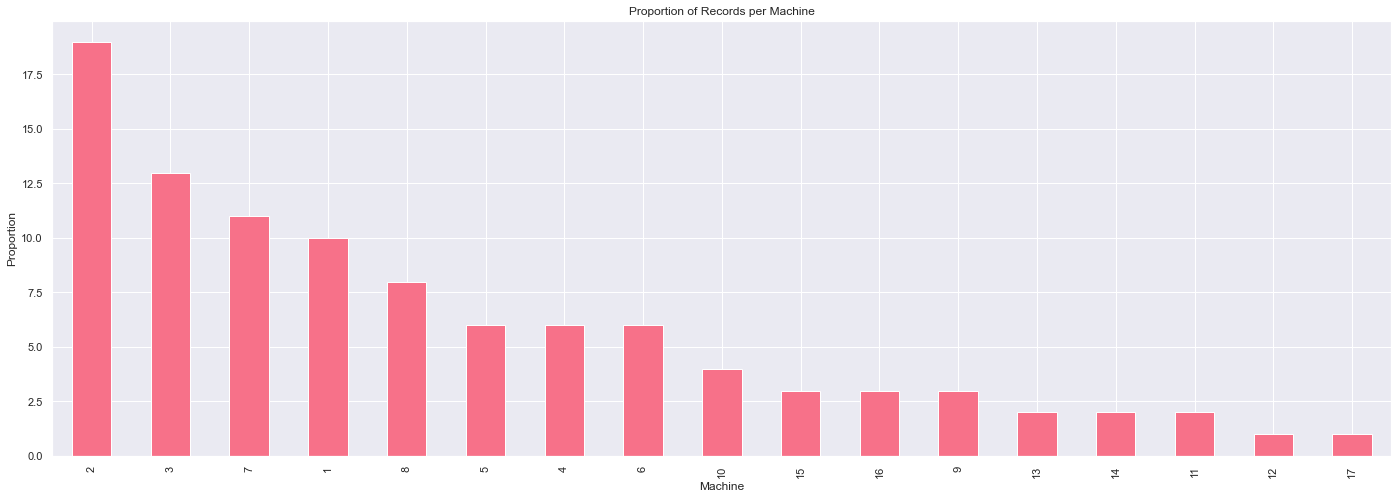

In [32]:
# plot each Machines's proportion of the total
# HINT: for a simple bar chart you can call .plot() on a pd.Series or pd.DataFrame
machine_counts.plot(
    kind='bar', 
    title='Proportion of Records per Machine', 
    xlabel='Machine', 
    ylabel='Proportion'
);

### Shifts

In [19]:
# get the total number of unique Shifts in the data as well as the proportion of the total (i.e. normalized count)
shift_counts = round(copper_df['Shift'].value_counts(normalize=True),2)*100
print(f'The total number of Shifts: {len(shift_counts)}')
shift_counts

The total number of Shifts: 2


A    51.0
B    49.0
Name: Shift, dtype: float64

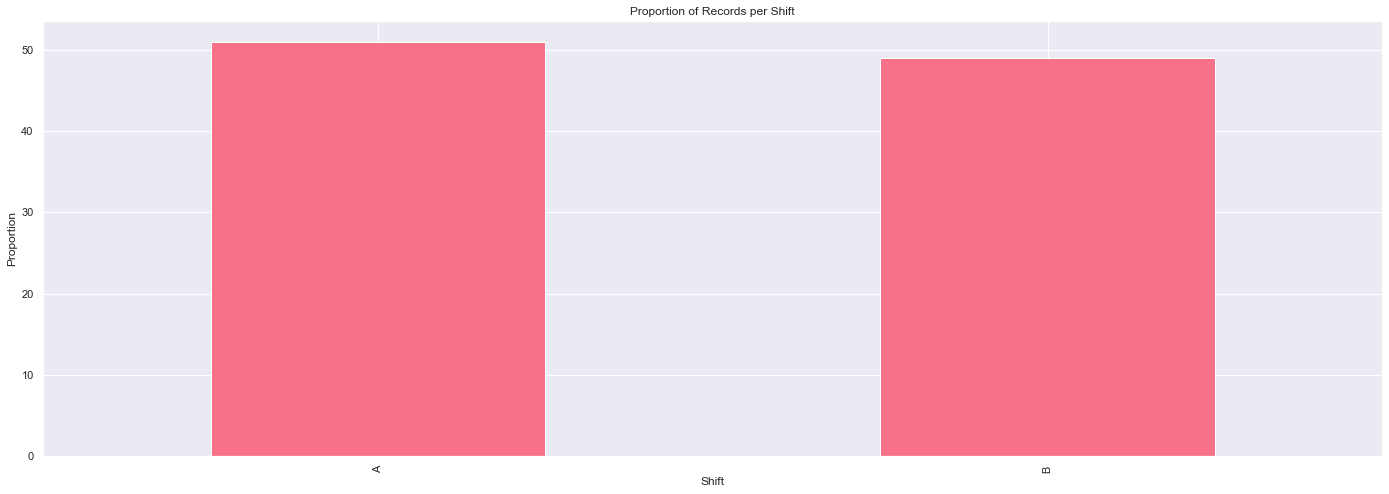

In [20]:
# plot each Shift's proportion of the total
shift_counts.plot(
    kind='bar', 
    title='Proportion of Records per Shift', 
    xlabel='Shift', 
    ylabel='Proportion'
);

### Operator Names

In [26]:
# get the total number of unique Operator Names in the data as well as the proportion of the total (i.e. normalized count)
operator_counts = round(copper_df['Operator Name'].value_counts(normalize=True),2)*100
print(f'The total number of Operators: {len(operator_counts)}')
operator_counts

The total number of Operators: 32


Fritz M          9.0
Courtney H       8.0
Byron B          6.0
Hess H           6.0
Elliott V        6.0
Rodney G         6.0
Maurice O        6.0
Floyd G          5.0
Woodrow S        5.0
Marcel C         5.0
Lilly Z          4.0
Tad S            3.0
Joesph W         3.0
Norris H         3.0
Archy B          3.0
Jose G           3.0
Connie M         3.0
Diego S          2.0
Bennett W        2.0
Harlan B         2.0
Dudley S         2.0
Francisco L      1.0
Hugh R           1.0
Vince F          1.0
Delmer K         1.0
Nichole H        1.0
Gonzalo J        1.0
Christopher G    1.0
David S          1.0
Roland M         1.0
Lindsey F        1.0
Eugene W         1.0
Name: Operator Name, dtype: float64

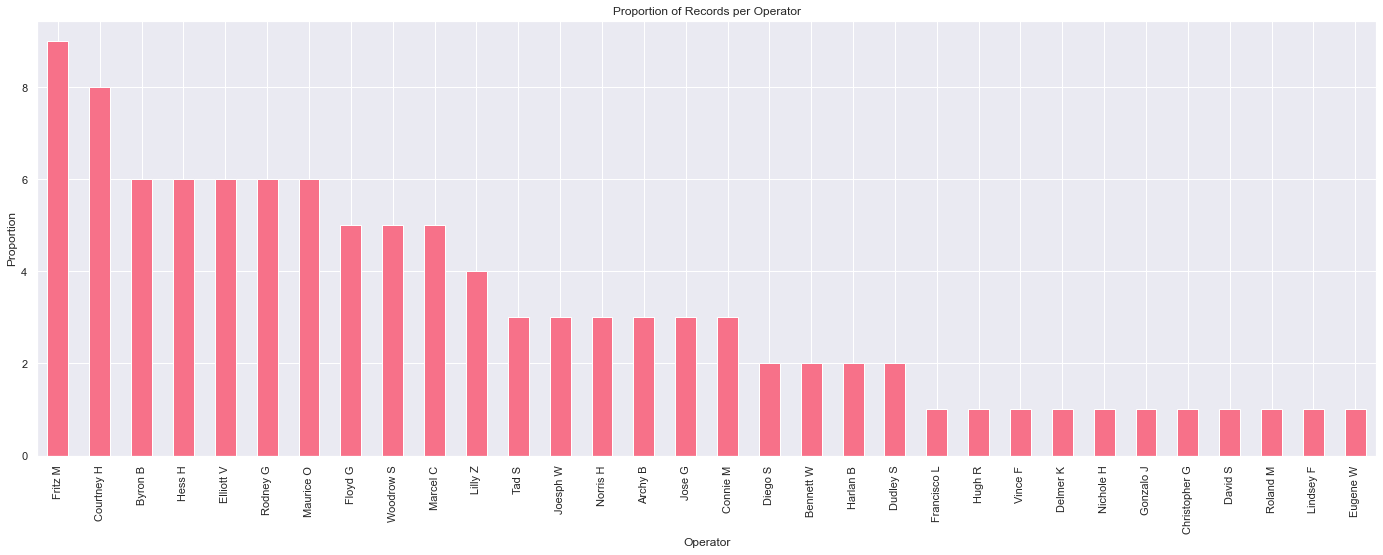

In [22]:
# plot each Operators's proportion of the total
operator_counts.plot(
    kind='bar', 
    title='Proportion of Records per Operator', 
    xlabel='Operator', 
    ylabel='Proportion'
);

## How many unique combinations of Machine-Shift-Operator Name? Plot the proportion of the total for each.

In [27]:
# get the total number of unique Machine-Shift-Operator Name combinations in the data as well as the proportion of the total (i.e. normalized count)
combo_counts = round(copper_df[['Machine','Shift','Operator Name']].value_counts(normalize=True),2)*100
print(f'The total number of unique Machine-Shift-Operator combinations: {len(combo_counts)}')
combo_counts

The total number of unique Machine-Shift-Operator combinations: 65


Machine  Shift  Operator Name
7        B      Fritz M          7.0
1        A      Courtney H       5.0
3        B      Maurice O        3.0
2        B      Hess H           3.0
7        A      Byron B          3.0
                                ... 
                Marcel C         1.0
8        A      Diego S          1.0
                Rodney G         1.0
         B      Diego S          1.0
17       A      Floyd G          1.0
Length: 65, dtype: float64

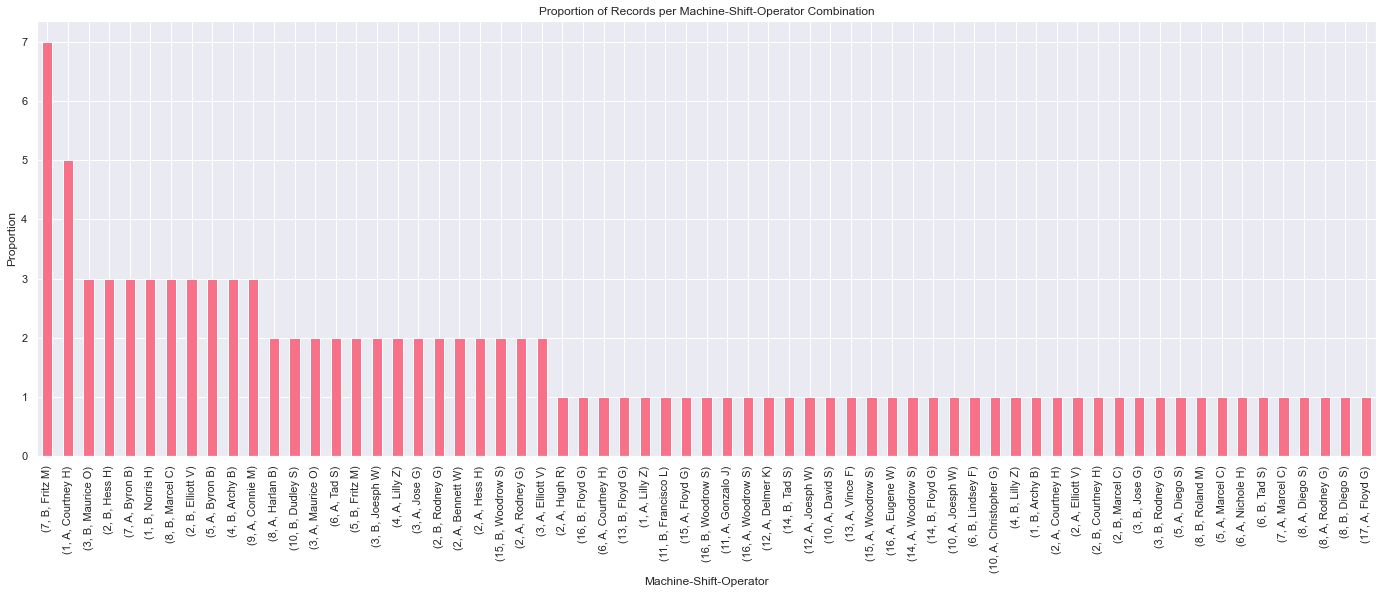

In [24]:
# plot the count of unique Machine-Shift-Operator combinations
combo_counts.plot(
    kind='bar', 
    title='Proportion of Records per Machine-Shift-Operator Combination', 
    xlabel='Machine-Shift-Operator', 
    ylabel='Proportion'
);

## How many dates are included in the data?

In [21]:
# get the total number of Dates in the data as well as how many records exist for each
date_counts = copper_df['Date'].value_counts()
print(f'The total number of Dates: {len(date_counts)}')
date_counts

The total number of Dates: 16


2020-11-10    14
2020-11-14    13
2020-11-21    13
2020-11-22    13
2020-11-17    12
2020-11-15    12
2020-11-13    12
2020-11-18    10
2020-11-12     9
2020-11-19     8
2020-11-20     7
2020-11-16     7
2020-11-09     6
2020-11-08     4
2020-11-06     3
2020-11-07     2
Name: Date, dtype: int64

### Are any dates that should be covered by the range of the data missing? If so, which and how could this be addressed?

In [22]:
# identify if any dates are missing in the data
# if so, explain how the missing data could be addressed

## Create 'Day of Week' column

In [23]:
# insert a new column indicating the day of the week e.g., Monday
copper_df['Date'] = pd.to_datetime(copper_df['Date'])
copper_df['Day of Week'] = copper_df['Date'].dt.day_name()
copper_df.head()

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Day of Week
0,1,A,1,2020-11-06,1,35,1,30,Friday
1,1,A,1,2020-11-09,1,40,1,95,Monday
2,1,A,1,2020-11-14,1,10,0,0,Saturday
3,1,A,1,2020-11-17,0,0,1,30,Tuesday
4,1,A,1,2020-11-18,1,60,0,0,Wednesday


## Create 'Total Failures' & 'Total Downtime' columns

In [24]:
# insert two new columns to calculate the simple sum of failures & downtime for a given record
copper_df['Total Failures'] = copper_df['Cable Failures'] + copper_df['Other Failures']
copper_df['Total Failure Downtime'] = copper_df['Cable Failure Downtime'] + copper_df['Other Failure Downtime']
copper_df.head()

,Machine,Shift,Operator,Date,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Day of Week,Total Failures,Total Failure Downtime
0,1,A,1,2020-11-06,1,35,1,30,Friday,2,65
1,1,A,1,2020-11-09,1,40,1,95,Monday,2,135
2,1,A,1,2020-11-14,1,10,0,0,Saturday,1,10
3,1,A,1,2020-11-17,0,0,1,30,Tuesday,1,30
4,1,A,1,2020-11-18,1,60,0,0,Wednesday,1,60


## Plot the sum of downtimes by 'Date'

Below is an example of this plot.

![image](img/downtimes_by_date.PNG)

In [25]:
# prep the data, calculate sums
# HINT: you may want to group the data by Date & use an aggregation function like .sum()
by_date_df = copper_df.groupby('Date').sum()
by_date_df = by_date_df.sort_values('Date')
by_date_df.head()

,Machine,Operator,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Total Failures,Total Failure Downtime
Date,,,,,,,,
2020-11-06,5,6,4,85,6,290,10,375
2020-11-07,4,5,7,160,2,115,9,275
2020-11-08,8,22,3,220,1,40,4,260
2020-11-09,17,30,10,380,2,115,12,495
2020-11-10,87,177,27,915,3,55,30,970


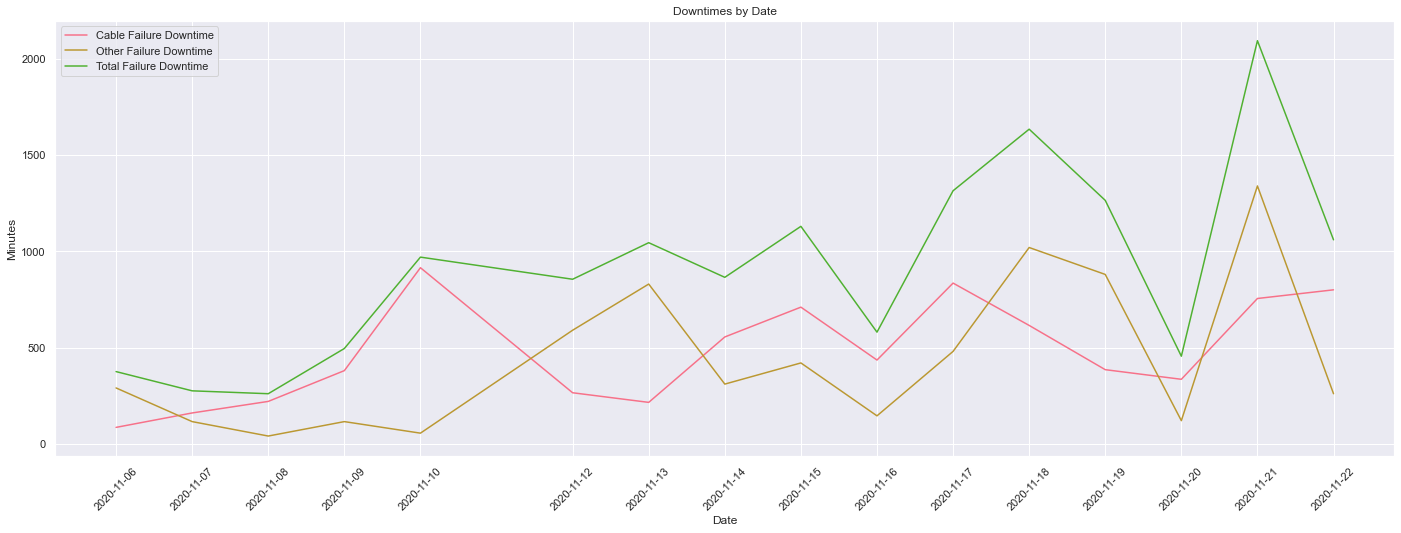

In [26]:
# line chart with 'Date' along the x-axis (in ascending chronological order), minutes along the y-axis, & three lines: Cable Failure Downtime, Other Failure Downtime, & Total Failure Downtime
# HINT: you'll likely want to call plt.plot() once for each line you're plotting 
plt.plot('Cable Failure Downtime', data=by_date_df)
plt.plot('Other Failure Downtime', data=by_date_df)
plt.plot('Total Failure Downtime', data=by_date_df)

plt.title('Downtimes by Date')
plt.ylabel('Minutes')
plt.xlabel('Date')
plt.xticks([i for i in by_date_df.index])
plt.xticks(rotation=45)

plt.legend();

## Plot the mean downtime by 'Day of Week'

In [27]:
# prep the data, calculate means
by_weekday_df = copper_df.groupby('Day of Week').mean()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
by_weekday_df = by_weekday_df.reindex(weekday_order)
by_weekday_df.head()

,Machine,Operator,Cable Failures,Cable Failure Downtime,Other Failures,Other Failure Downtime,Total Failures,Total Failure Downtime
Day of Week,,,,,,,,
Monday,4.615385,9.153846,1.846154,62.692308,0.384615,20.000000,2.230769,82.692308
Tuesday,6.192308,13.653846,1.769231,67.307692,0.384615,20.576923,2.153846,87.884615
Wednesday,5.800000,15.100000,1.600000,61.500000,0.800000,102.000000,2.400000,163.500000
Thursday,4.941176,13.176471,1.235294,38.235294,0.294118,86.470588,1.529412,124.705882
Friday,5.909091,12.409091,1.045455,28.863636,0.772727,56.363636,1.818182,85.227273


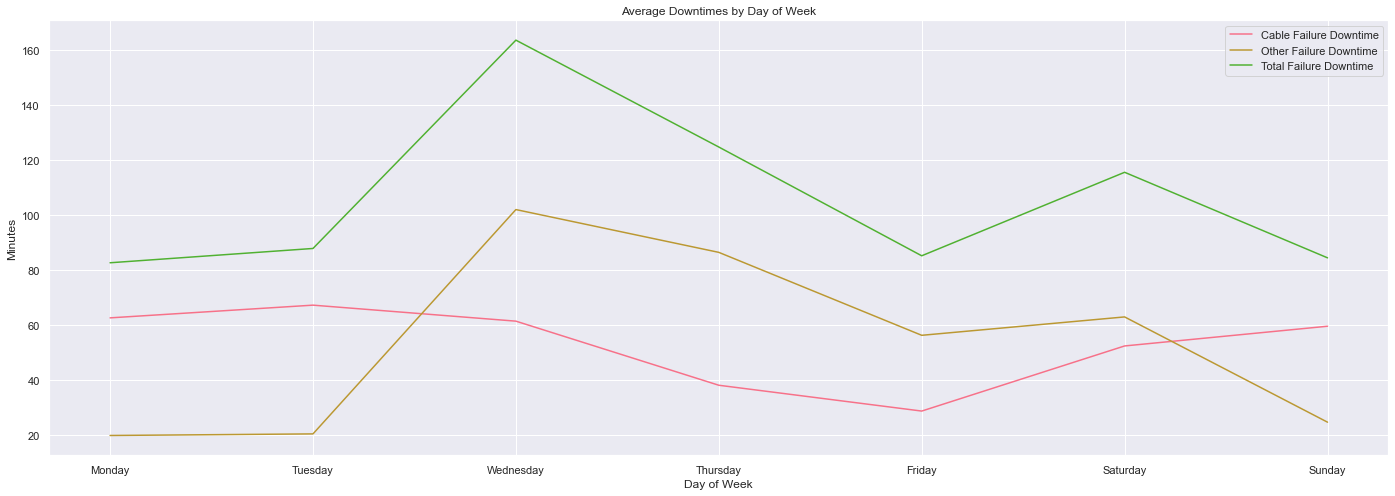

In [28]:
# line chart with 'Day of Week' along the x-axis, minutes along the y-axis, & three lines: Cable Failure Downtime, Other Failure Downtime, & Total Failure Downtime
plt.plot('Cable Failure Downtime', data=by_weekday_df)
plt.plot('Other Failure Downtime', data=by_weekday_df)
plt.plot('Total Failure Downtime', data=by_weekday_df)

plt.title('Average Downtimes by Day of Week')
plt.ylabel('Minutes')
plt.xlabel('Day of Week')

plt.legend();

# End